In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Churn_Modelling.csv')
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['Gender'] = encoder.fit_transform(data['Gender'])
data['Geography'] = encoder.fit_transform(data['Geography'])

In [5]:
x = data.drop(['Exited'], axis=1)
y = data['Exited']

In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

x1, y1 = smote.fit_resample(x, y)

print('Original datashape', y.value_counts())
print('Resample datashape', y1.value_counts())

Original datashape 0    7963
1    2037
Name: Exited, dtype: int64
Resample datashape 1    7963
0    7963
Name: Exited, dtype: int64


In [7]:
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.3, random_state=123)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [9]:
import pickle
model = pickle.load(open('model_tuned.pkl', 'rb'))
model.predict(X_test)

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

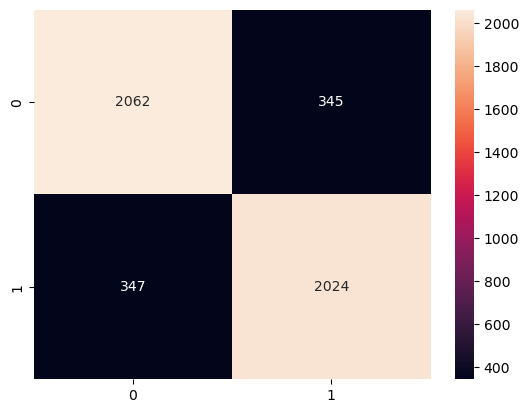

In [10]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.savefig('Optimized_forest_matrix.png')

In [11]:
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
run_metrics

{'accuracy': 0.86, 'precision': 0.85, 'recall': 0.85, 'entropy': 0.34}

In [12]:
def create_experiment(experiment_name,run_name, run_metrics,model, confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params=None):
    import mlflow
    # mlflow.set_tracking_uri("http://localhost:1234") #uncomment this line if you want to use any database like sqlite as backend storage for model
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')
            
        
        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Basic classifier", "tag3":"Production"})
        mlflow.sklearn.log_model(model, "model")
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))


Starting ML Flow Server

we will use sqlite as backend, so Now run this command to start mlflow with backend.

`mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 5000`

In [13]:
experiment_name = "Churn model"
run_name="Grid_Search_CV_Tuned_Model"
create_experiment(experiment_name,run_name,run_metrics,model,'optimized_forest_matrix.png')

2022/12/19 12:57:37 INFO mlflow.tracking.fluent: Experiment with name 'Churn model' does not exist. Creating a new experiment.
2022/12/19 12:57:37 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Run - Grid_Search_CV_Tuned_Model is logged to Experiment - Churn model
